In [1]:
import numpy as np
import pandas as pd
import joblib
import sys, os
sys.path.insert(0, '/home/monte.flora/python_packages/WoF_post')
sys.path.insert(0, '/home/monte.flora/python_packages/ml_workflow')
sys.path.insert(0, '/home/monte.flora/python_packages/wofs_ml_severe')

from wofs_ml_severe.io.load_ml_models import load_ml_model
from wofs_ml_severe.data_pipeline.local_explainer import LocalExplainer

from wofs.post.utils import load_yaml
import skexplain 
from skexplain.common.importance_utils import to_skexplain_importance 
from display_names import to_display_name, to_units, to_color, map_to_readable_names

In [2]:
time = 'second_hour'
target = 'all_sig_severe'
retro = False
file_log = None
resample = None

ml_config = load_yaml(
    '/home/monte.flora/python_packages/wofs_ml_severe/wofs_ml_severe/conf/ml_config_retro.yml')

parameters = {
                'target' : target,
                'time' : time, 
                'drop_opt' : '',
                'model_name' : 'LogisticRegression',
                'ml_config' : ml_config,
                'file_log'  : file_log,
                'resample' : resample
            }

model_dict = load_ml_model(retro, **parameters)
model = model_dict['model']
features = model_dict['X'].columns

X_train = model_dict['X']

Loading /work/mflora/ML_DATA/NEW_ML_MODELS/LogisticRegression_all_sig_severe_None_second_hour_realtime.joblib...


### Top features based on the raw logistic regression coefficients

In [3]:
base_est = model.calibrated_classifiers_[0].base_estimator

# Get the model coefficients. 
coef = base_est.named_steps['model'].coef_[0, :]

coef_rank = to_skexplain_importance(coef, estimator_name='LR', feature_names=features, 
                                   method = 'coefs',
                                    normalize=False,
                                   )

In [4]:
coef_rank['coefs_rankings__LR'].values[:8]

array(['hailcast__time_max__amp_ens_mean_spatial_perc_90',
       'uh_2to5_instant__time_max__ens_std__spatial_mean',
       'w_up__time_max__amp_ens_mean_spatial_perc_90',
       'ws_80__time_max__amp_ens_mean_spatial_perc_90',
       'shear_u_0to6__ens_mean__spatial_mean',
       'w_down__time_min__amp_ens_mean_spatial_perc_10',
       'ctt__time_min__amp_ens_mean_spatial_perc_10',
       'shear_v_0to1__ens_mean__spatial_mean'], dtype=object)

In [5]:
display_feature_names = {f : to_display_name(f) for f in coef_rank['coefs_rankings__LR'].values}
feature_colors = {f : to_color(f) for f in coef_rank['coefs_rankings__LR'].values}

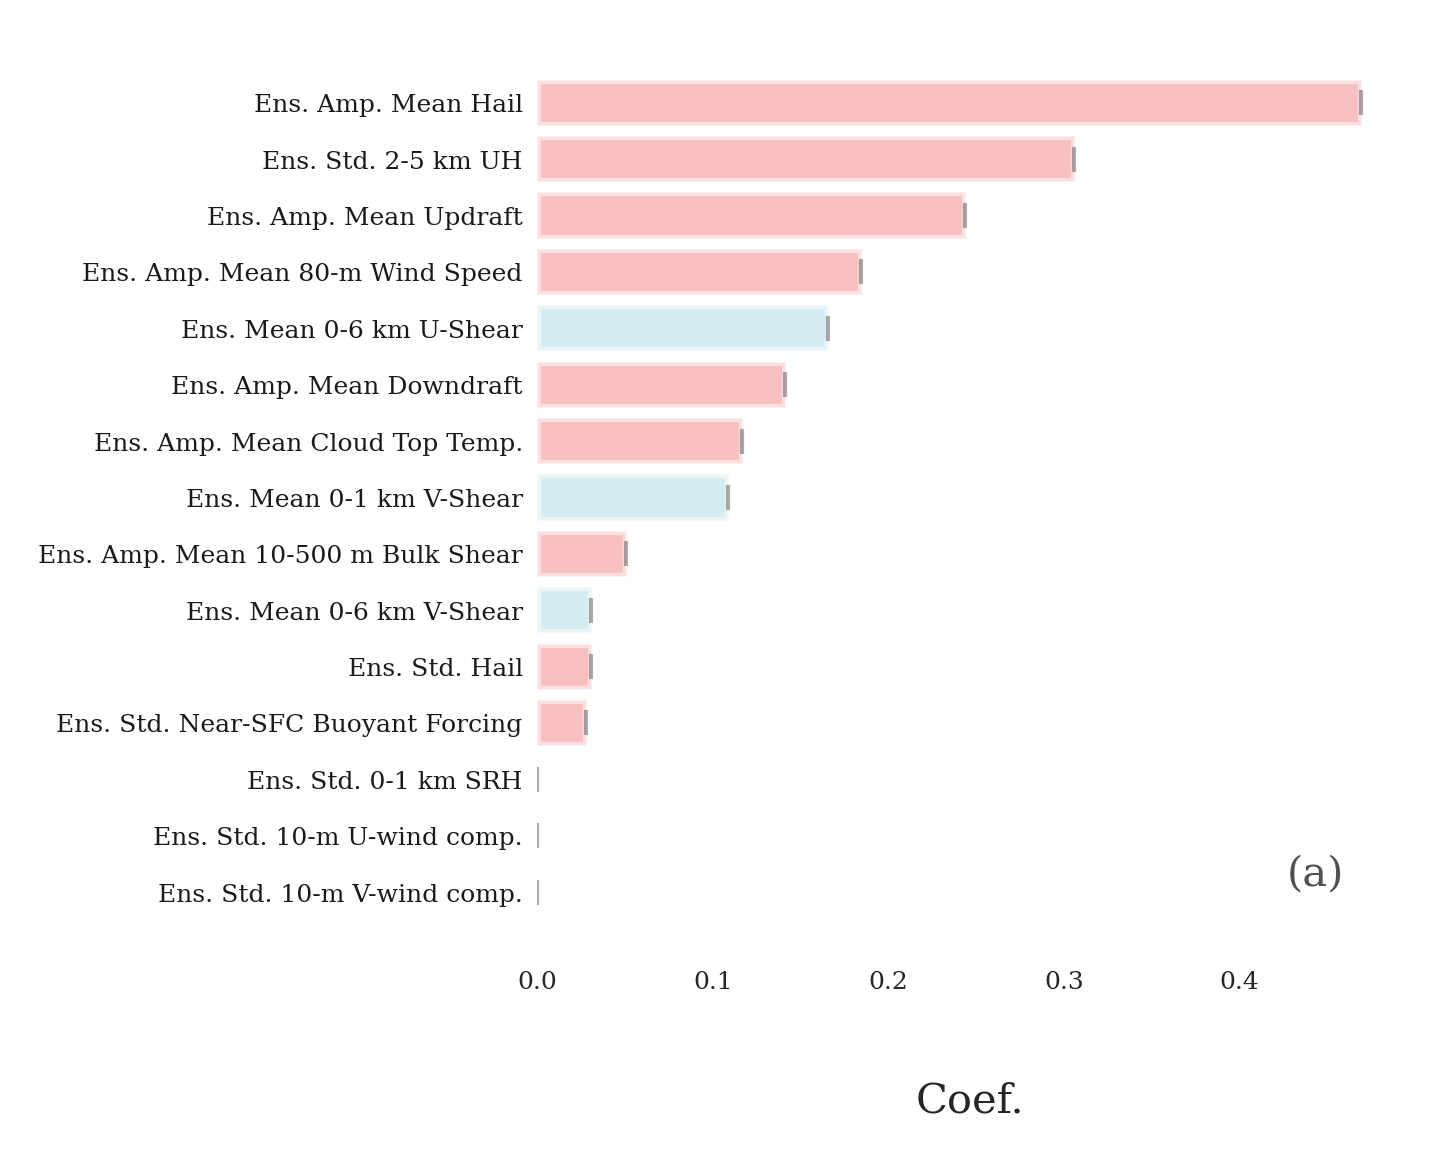

In [6]:
%matplotlib inline
data = [coef_rank]
panels = [('coefs', 'LR'), 
          ]

explainer = skexplain.ExplainToolkit()
fig = explainer.plot_importance(data=data, 
                                panels=panels, 
                                num_vars_to_plot=15, 
                                figsize=(5,4), 
                                display_feature_names = display_feature_names,
                                feature_colors = feature_colors, 
                               )

In [7]:
base_names = np.unique([f.split('__')[0] for f in features])

coefs_summed = np.zeros(len(base_names))
for i, name in enumerate(base_names):
    coefs_summed[i] = np.sum([c for f,c in zip(features, coef) if name in f])
 
coef_rank_sum = to_skexplain_importance(coefs_summed, 
                                        estimator_name='LR', 
                                        feature_names=base_names, 
                                        method = 'coefs'
                                   )

In [8]:
coef_rank_sum['coefs_rankings__LR'].values[:8]

array(['hailcast', 'uh_2to5_instant', 'w_up', 'ws_80', 'shear_u_0to6',
       'w_down', 'ctt', 'shear_v_0to1'], dtype='<U20')

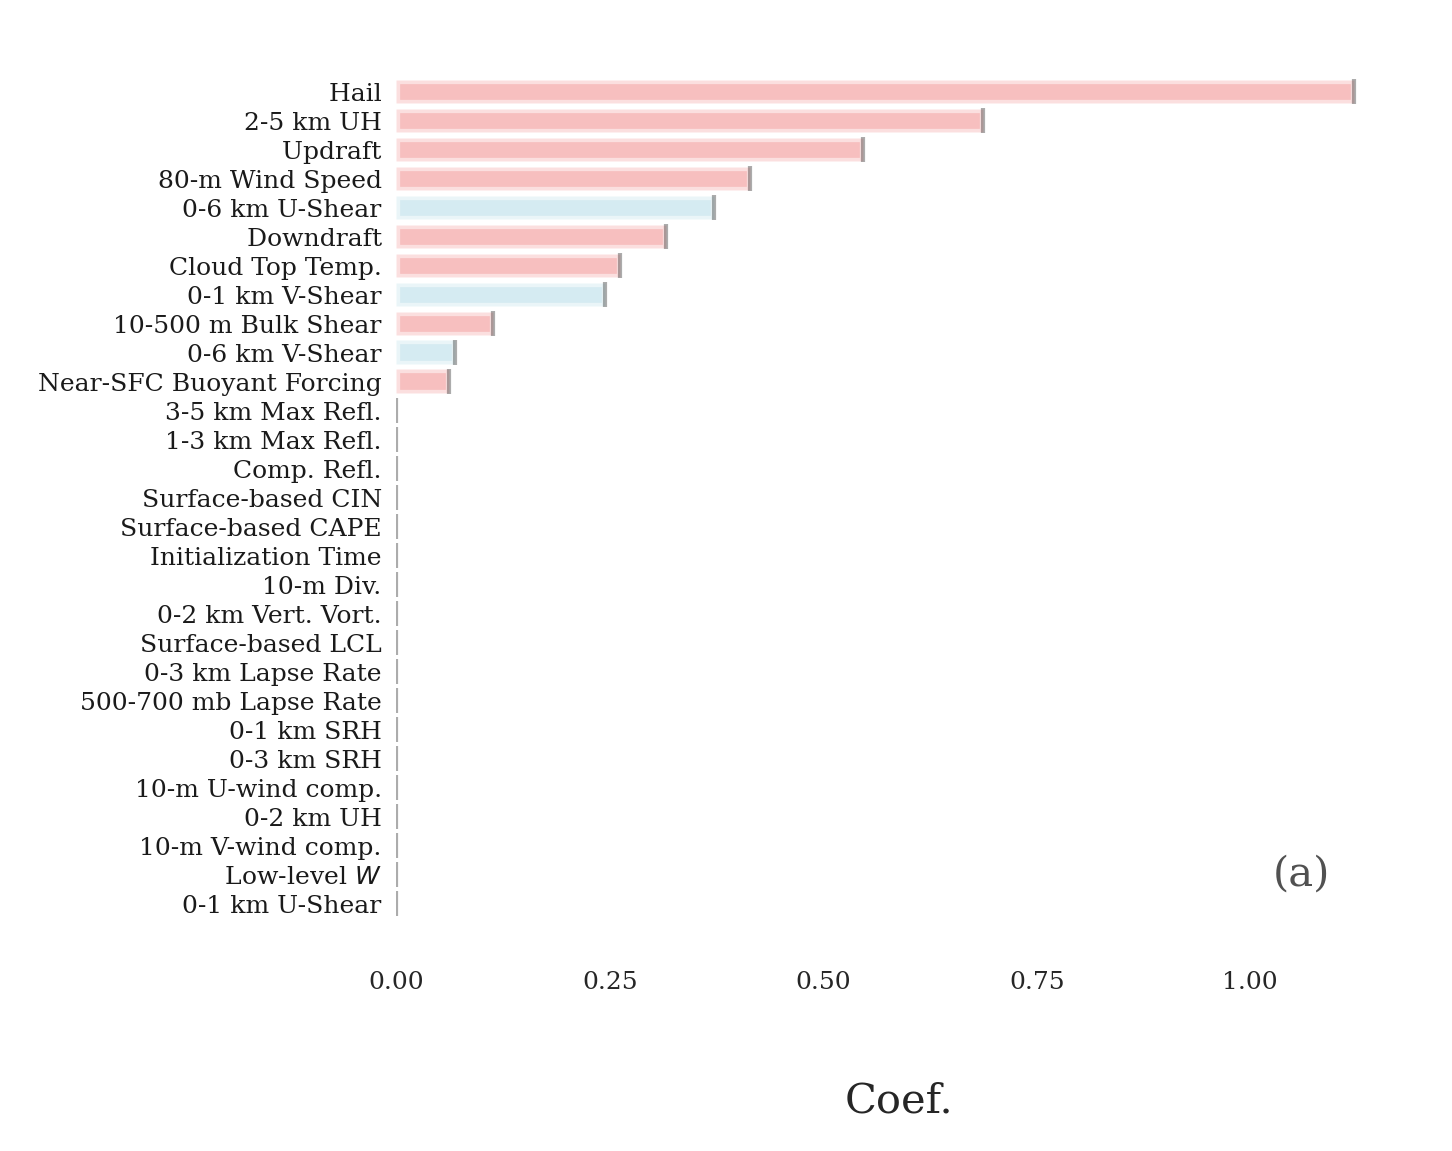

In [9]:
%matplotlib inline
data = [coef_rank_sum]
panels = [('coefs', 'LR'), 
          ]


display_feature_names = {f.split('__')[0] : map_to_readable_names[f.split('__')[0]] 
                         for f in features}
feature_colors = {f.split('__')[0] : to_color(f) for f in features}


explainer = skexplain.ExplainToolkit()
fig = explainer.plot_importance(data=data, 
                                panels=panels, 
                                num_vars_to_plot=100, 
                                figsize=(5,4), 
                                display_feature_names = display_feature_names,
                                feature_colors = feature_colors, 
                               )

In [10]:
scores = coef_rank_sum['coefs_scores__LR'].values[:,0]

drop_vars = list(coef_rank_sum['coefs_rankings__LR'].values[scores<0.3])

In [11]:
drop_vars

['ctt',
 'shear_v_0to1',
 '10-500m_bulkshear',
 'shear_v_0to6',
 'buoyancy',
 'dbz_3to5',
 'dbz_1to3',
 'comp_dz',
 'cin_sfc',
 'cape_sfc',
 'Initialization Time',
 'div_10m',
 'wz_0to2_instant',
 'lcl_sfc',
 'low_level_lapse_rate',
 'mid_level_lapse_rate',
 'srh_0to1',
 'srh_0to3',
 'u_10',
 'uh_0to2_instant',
 'v_10',
 'w_1km',
 'shear_u_0to1']

In [12]:
torn_removed = ['shear_v_0to1',
 'comp_dz',
 'srh_0to1',
 'lcl_sfc',
 'geo_hgt_500',
 'shear_u_0to1',
 'temperature_500',
 'geo_hgt_700',
 'geo_hgt_850',
 'Initialization Time',
 'temperature_700',
 'u_10',
 'shear_u_0to6',
 'hailcast',
 'td_700',
 'avg_updraft_track_area',
 'theta_e',
 'td_850']

wind_removed = ['mid_level_lapse_rate',
 'uh_2to5_instant',
 '10-500m_bulkshear',
 'u_10',
 'cin_sfc',
 'hailcast',
 'dbz_1to3',
 'w_up',
 'td_700',
 'srh_0to3',
 'temperature_850',
 'shear_u_0to6',
 'dbz_3to5',
 'shear_u_0to1',
 'uh_0to2_instant',
 'td_850',
 'Initialization Time',
 'temperature_500',
 'shear_v_0to6',
 'shear_v_0to1',
 'geo_hgt_850',
 'geo_hgt_500',
 'td_500',
 'geo_hgt_700',
 'cape_sfc',
 'low_level_lapse_rate',
 'srh_0to1']

hail_removed = ['geo_hgt_850',
 'theta_e',
 'cape_sfc',
 'srh_0to3',
 'temperature_500',
 'td_700',
 'w_down',
 'Initialization Time',
 'cin_sfc',
 'geo_hgt_500',
 'hailcast',
 'shear_u_0to1',
 'td_850',
 'mid_level_lapse_rate',
 'shear_v_0to6',
 'u_10',
 'uh_0to2_instant',
 'temperature_700',
 'shear_v_0to1',
 'wz_0to2_instant',
 'geo_hgt_700',
 'srh_0to1']

final_set = torn_removed+hail_removed+wind_removed
print(set(final_set))

{'cape_sfc', 'uh_0to2_instant', 'lcl_sfc', 'geo_hgt_850', 'comp_dz', 'w_up', 'srh_0to1', 'srh_0to3', 'w_down', 'td_850', 'u_10', 'temperature_850', 'geo_hgt_700', '10-500m_bulkshear', 'cin_sfc', 'avg_updraft_track_area', 'temperature_700', 'shear_v_0to6', 'shear_u_0to6', 'dbz_3to5', 'shear_v_0to1', 'dbz_1to3', 'hailcast', 'Initialization Time', 'low_level_lapse_rate', 'theta_e', 'mid_level_lapse_rate', 'temperature_500', 'td_500', 'geo_hgt_500', 'shear_u_0to1', 'wz_0to2_instant', 'uh_2to5_instant', 'td_700'}
